# Evaluation

This Notebook contains the evaluation of all used machine learning models during this project. \
Evaluation and Validation will be performed on the test and validation data 

In [1]:
# Imports
import numpy as np
import sys

sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from model.helpers import *
from model.predict import *
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
import seaborn as sns

from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)

In [2]:
# load data
TRAIN = {}
TEST = {}
VALIDATION = {}

path = "../../data/master/"
train = "train_"
test = "test_"
validation = "validation_"
#  list of scenarios
scenarios = [
    "CVE-2012-2122",
    "CVE-2014-0160",
    "CVE-2017-7529",
    "CVE-2017-12635_6",
    "CVE-2018-3760",
    "CVE-2019-5418",
    "CVE-2020-9484",
    "CVE-2020-13942",
    "CVE-2020-23839",
    "CWE-89-SQL-injection",
]

for i in range(0, len(scenarios)):
    TRAIN[scenarios[i]] = pd.read_pickle(path + "/" + train + scenarios[i] + ".pkl")
    TEST[scenarios[i]] = pd.read_pickle(path + "/" + test + scenarios[i] + ".pkl")
    VALIDATION[scenarios[i]] = pd.read_pickle(
        path + "/" + validation + scenarios[i] + ".pkl"
    )

In [3]:
# load each model for each Scenario

model_type = "IsolationForest"
IsoForests = {}
for i in range(0, len(scenarios)):
    # get dict and save mofel for each scenario
    IsoForests[scenarios[i]] = load_model(
        model_type=model_type,
        train_data=TRAIN,
        test_data=TEST,
        scenario=scenarios[i],
        contamination_rate=False,
    )

model_type = "LocalOutlierFactor"
lof_ = {}
for i in range(0, len(scenarios)):
    # get dict and save mofel for each scenario
    lof_[scenarios[i]] = load_model(
        model_type=model_type,
        train_data=TRAIN,
        test_data=TEST,
        scenario=scenarios[i],
        contamination_rate=False,
    )

model_type = "VariationalAutoencoder"
vae = {}
for i in range(0, len(scenarios)):
    # get dict and save mofel for each scenario
    vae[scenarios[i]] = load_model(
        model_type=model_type,
        train_data=TRAIN,
        test_data=TEST,
        scenario=scenarios[i],
        contamination_rate=False,
    )

2023-03-15 14:06:26.893472: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


298/298 [==============================] - 0s 395us/step


In [4]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(TEST[scenarios[i]])[
        "exploit"
    ]  # remember 0 = inliners, 1 = outliers

### ROC-AUC Curve

4040/4040 [==============================] - 2s 395us/step


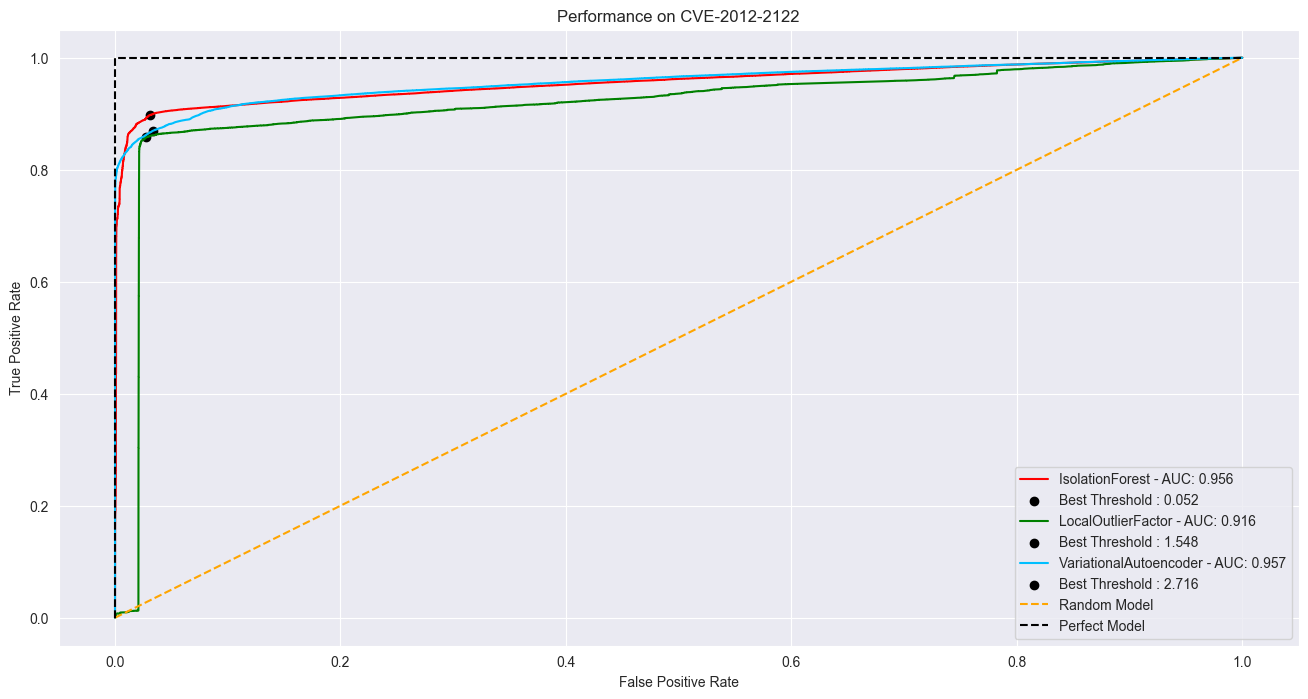

1156/1156 [==============================] - 0s 364us/step


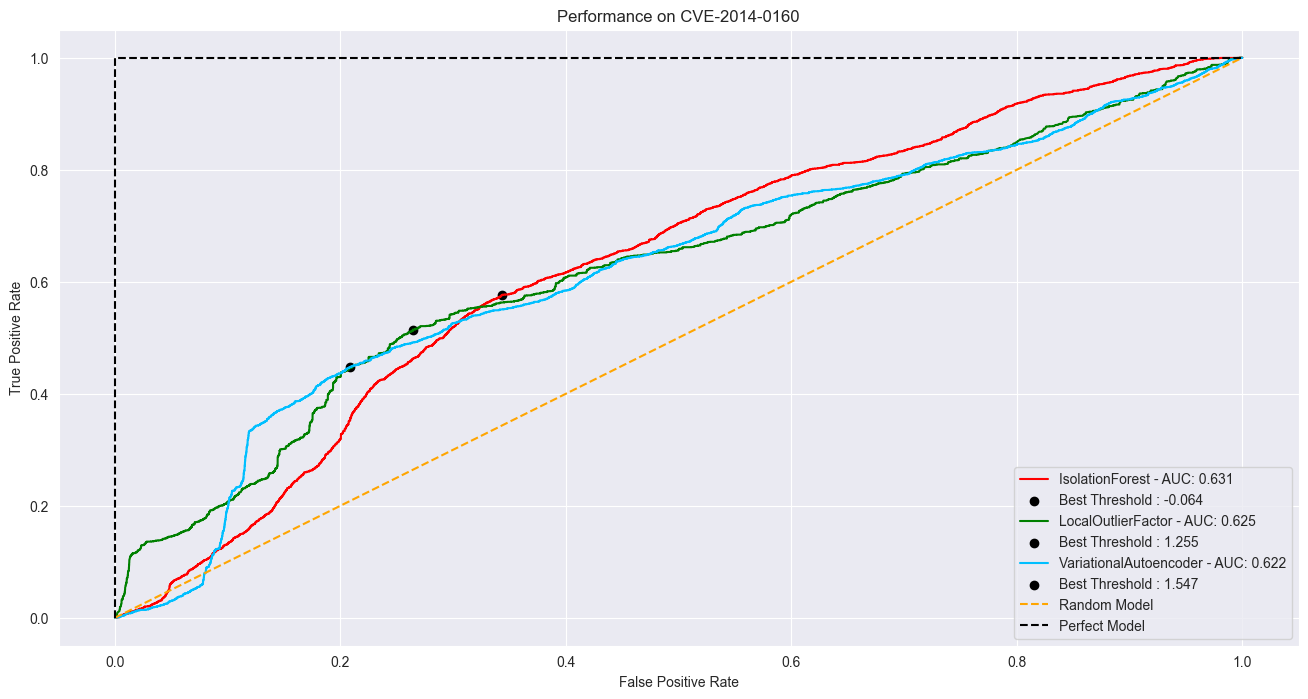

1101/1101 [==============================] - 0s 363us/step


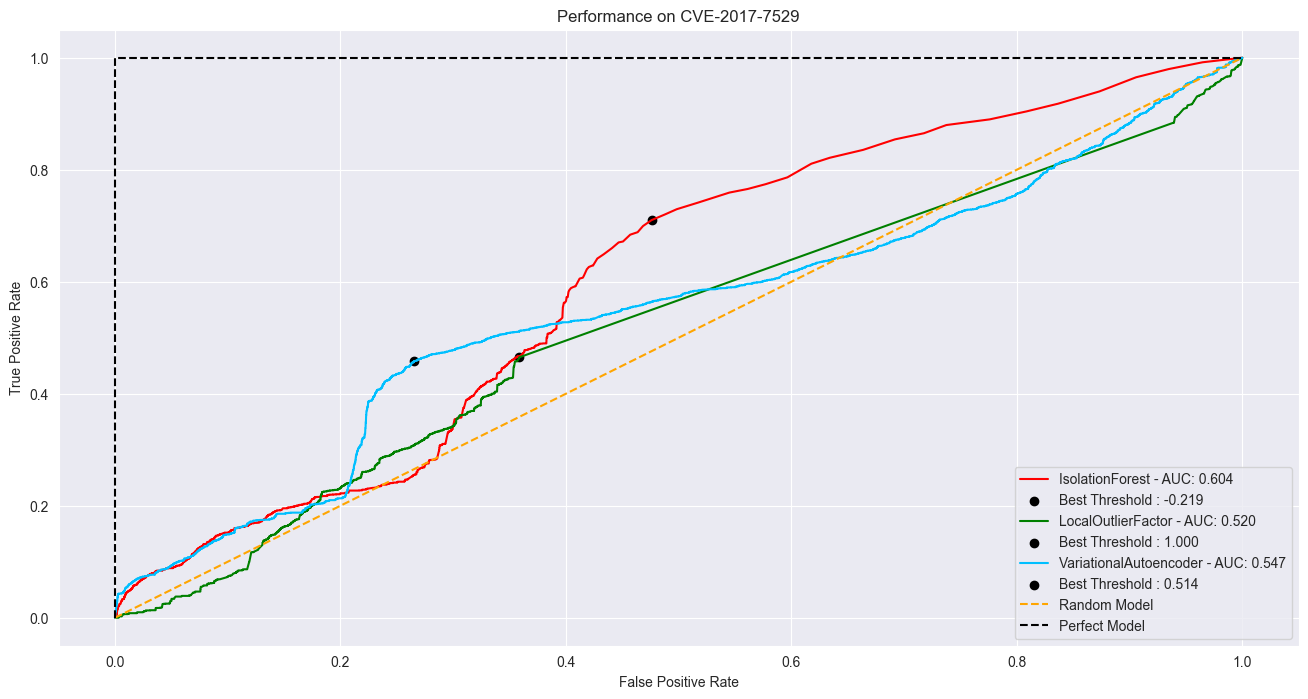

1169/1169 [==============================] - 0s 356us/step


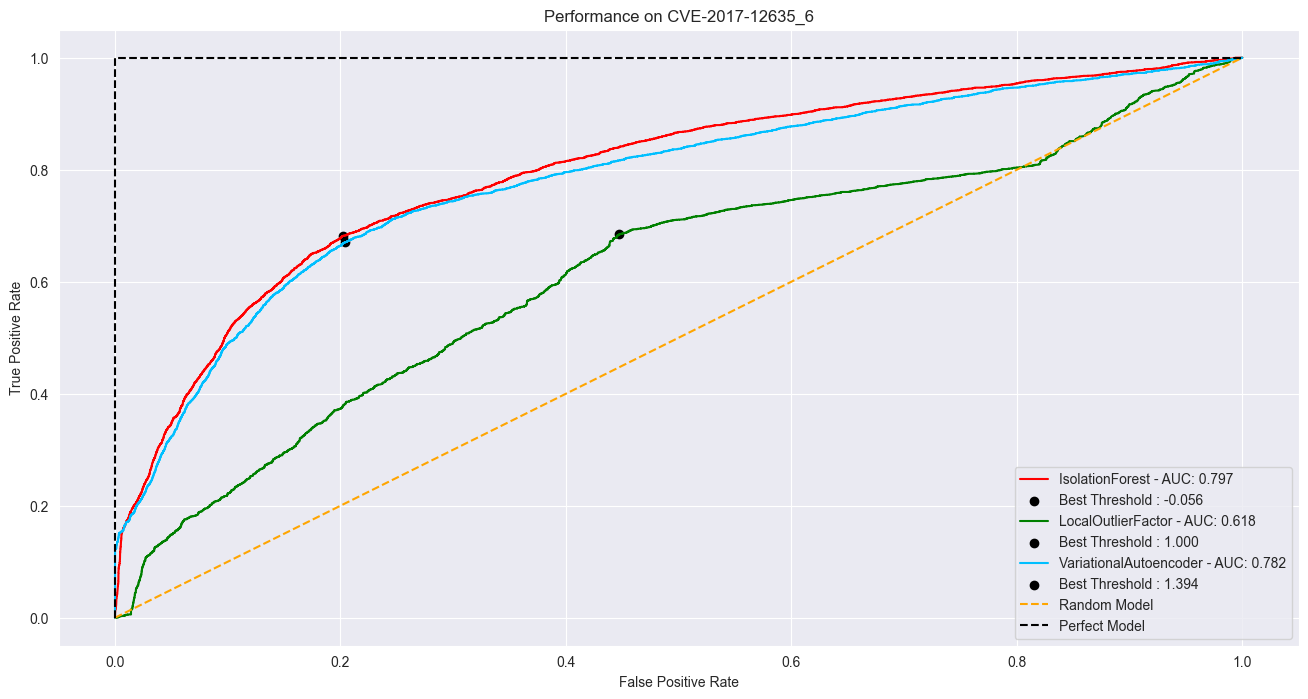

1117/1117 [==============================] - 0s 361us/step


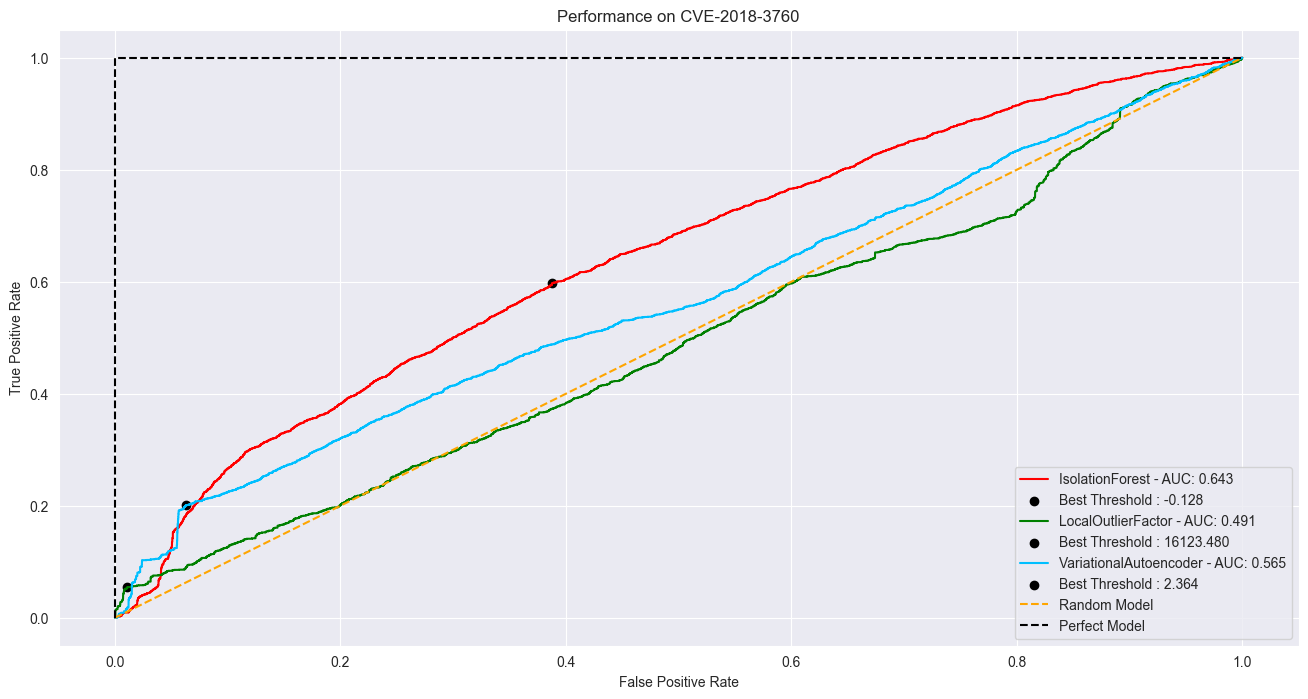

1165/1165 [==============================] - 0s 376us/step


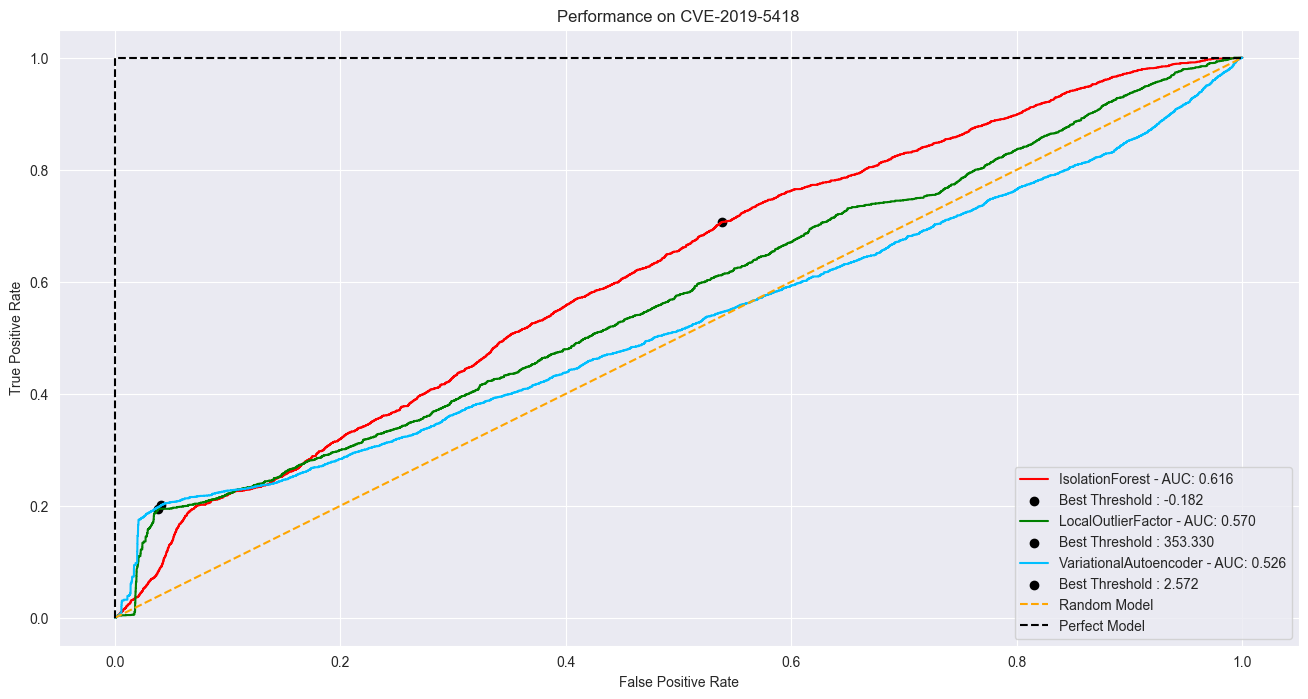

1183/1183 [==============================] - 0s 370us/step


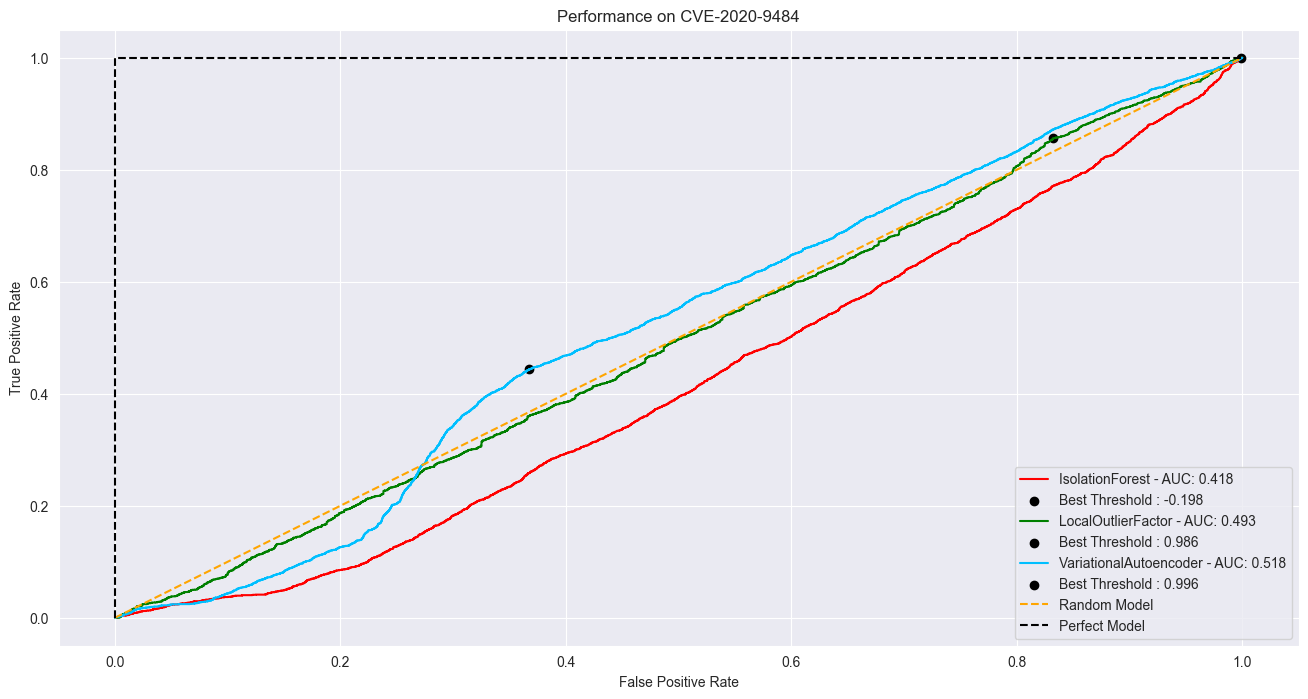

1150/1150 [==============================] - 0s 357us/step


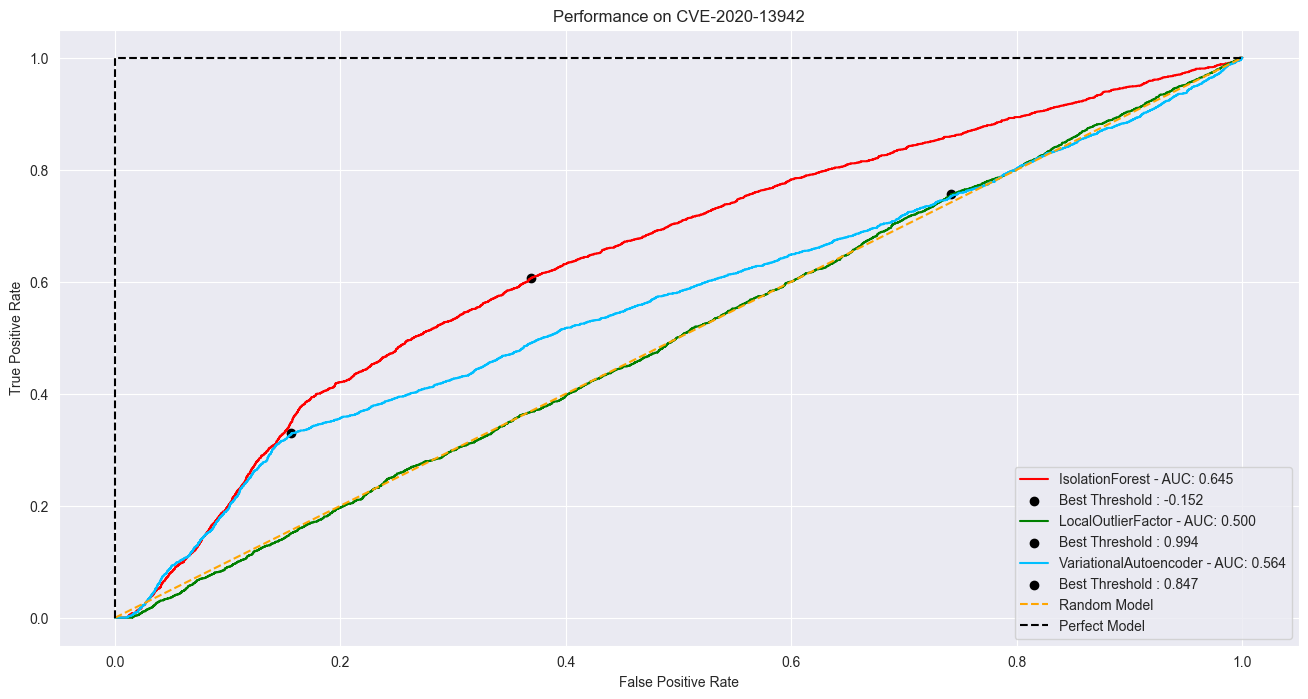

1248/1248 [==============================] - 0s 370us/step


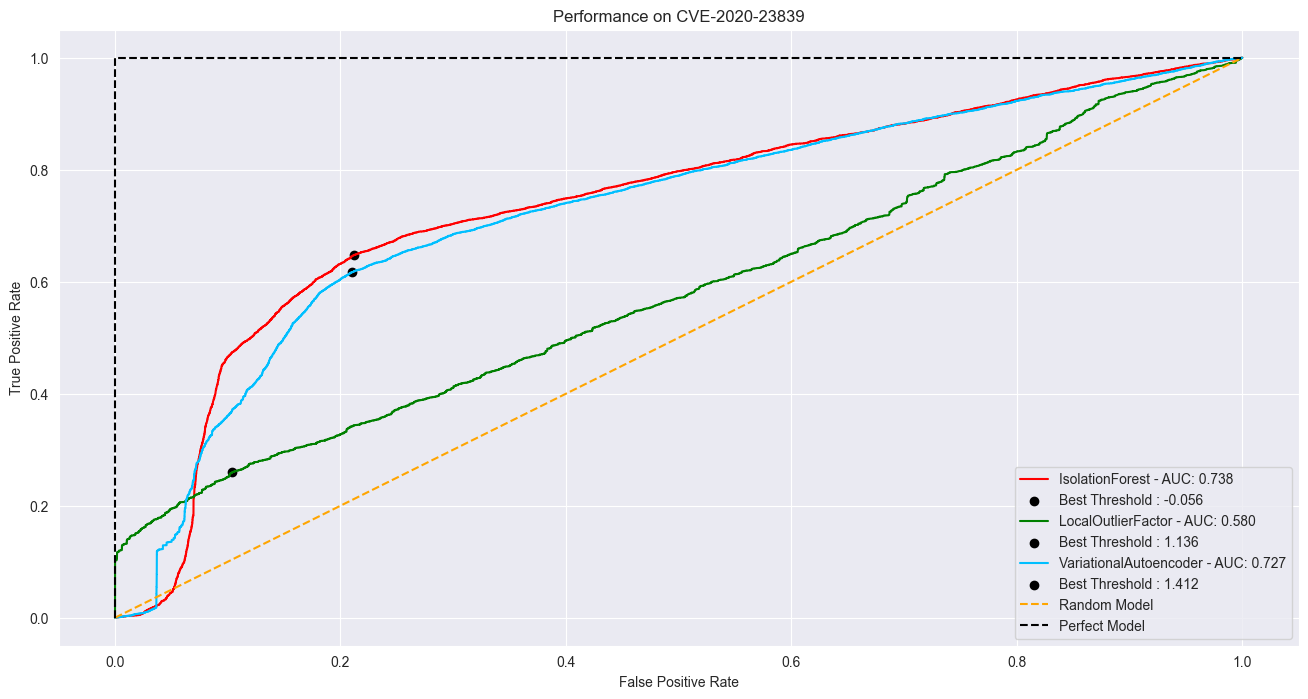

1207/1207 [==============================] - 0s 374us/step


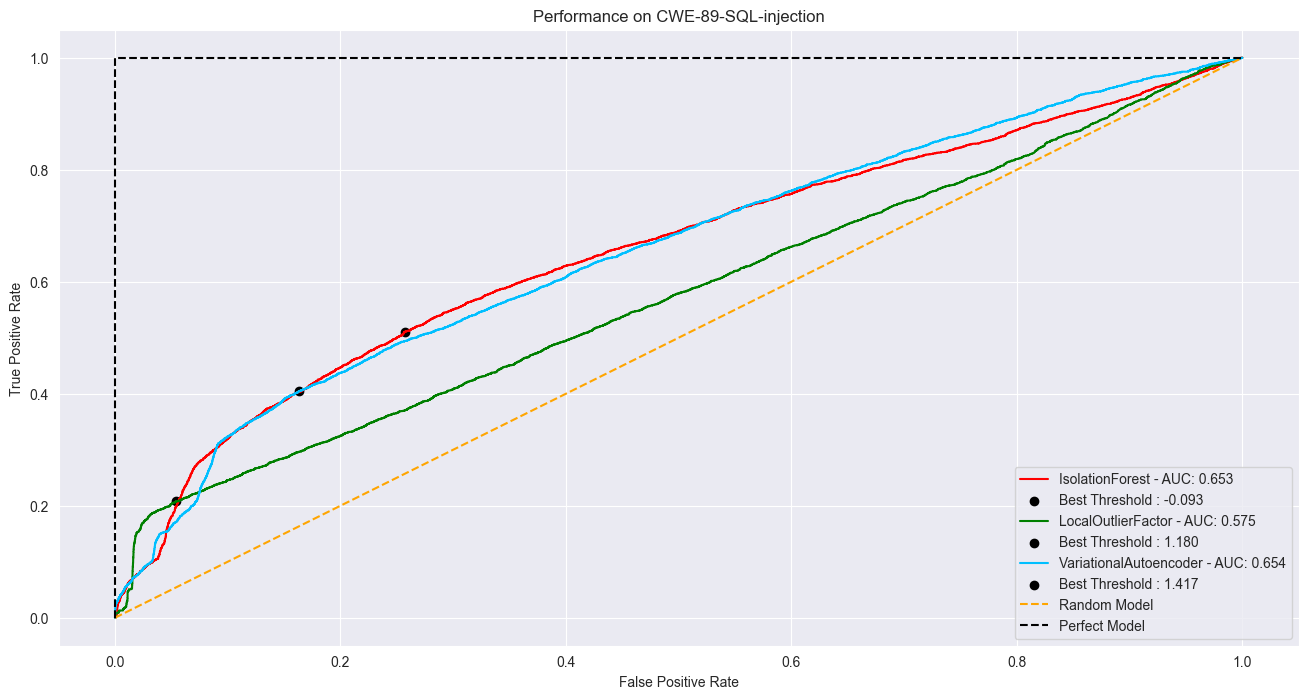

In [5]:
sns.set_style("darkgrid")
name = ["IsolationForest", "LocalOutlierFactor", "VariationalAutoencoder"]
colors = ["red", "green", "deepskyblue"]
# Create plots for all scenarios
for i in range(0, len(scenarios)):
    # prepare test data
    X_test = TEST[scenarios[i]]
    X_test = select_columns_for_modelling(X_test)

    algorithms = [IsoForests[scenarios[i]], lof_[scenarios[i]], vae[scenarios[i]]]

    fig = plt.figure(figsize=(16, 8))
    for a, algo in enumerate(algorithms):
        algo_test = algo.decision_function(X_test)

        fpr_test_, tpr_test_, thresholds = roc_curve(y_true[scenarios[i]], algo_test)
        algo_auc_test = auc(fpr_test_, tpr_test_)
        J = tpr_test_ - fpr_test_
        ix = np.argmax(J)
        best_thresh = thresholds[ix]
        # print(str(name[a]) + ': Best Threshold %f' % (best_thresh))

        plt.subplot(1, 1, 1)
        plt.title("Performance on " + scenarios[i])
        plt.plot(
            fpr_test_,
            tpr_test_,
            color=colors[a],
            label="{0} - AUC: {1:.3f}".format(name[a], algo_auc_test),
        )
        plt.scatter(
            fpr_test_[ix],
            tpr_test_[ix],
            marker="o",
            color="black",
            label="Best Threshold : {1:.3f}".format(name[a], best_thresh),
        )  # Ausssage nochmal nach prüfen!
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")

    plt.subplot(1, 1, 1)
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random Model", color="orange")
    plt.plot([0, 0, 1], [0, 1, 1], linestyle="--", label="Perfect Model", color="black")
    plt.legend(loc=0)
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))

    plt.show()
    fig.savefig("../../src/plots/models/EVALUATION_ALLMODELS_" + scenarios[i] + ".png")

### Evaluation after Outlier Truncation

Outliers will be truncated using the Interquartile Range (IQR)

In [6]:
no_outliers = {}
for i in range(0, len(scenarios)):
    normal = TEST[scenarios[i]][TEST[scenarios[i]]["exploit"] == False]
    attack = TEST[scenarios[i]][TEST[scenarios[i]]["exploit"] != False]
    # chose only cpu_usage and memory_usage
    normal = select_columns_outlier_truncate(normal)
    attack = select_columns_outlier_truncate(attack)
    # calculate IQR for each scenario
    Q1 = normal.quantile(0.25)
    Q3 = normal.quantile(0.75)
    IQR = Q3 - Q1
    normal = normal[
        ~((normal < (Q1 - 1.5 * IQR)) | (normal > (Q3 + 1.5 * IQR))).any(axis=1)
    ]
    no_outliers[scenarios[i]] = pd.concat([normal, attack])

In [7]:
# get all scenarios in one data set at the end
no_outliers_test = []
for key in no_outliers.keys():
    no_outliers[key]["scenario"] = key
    temp_df = no_outliers[key]
    no_outliers_test.append(temp_df)
no_outliers["ALL"] = pd.concat(no_outliers_test)

In [8]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(no_outliers[scenarios[i]])[
        "exploit"
    ]  # remember 0 = inliners, 1 = outliers

### ROC-AUC Curve

3983/3983 [==============================] - 1s 367us/step


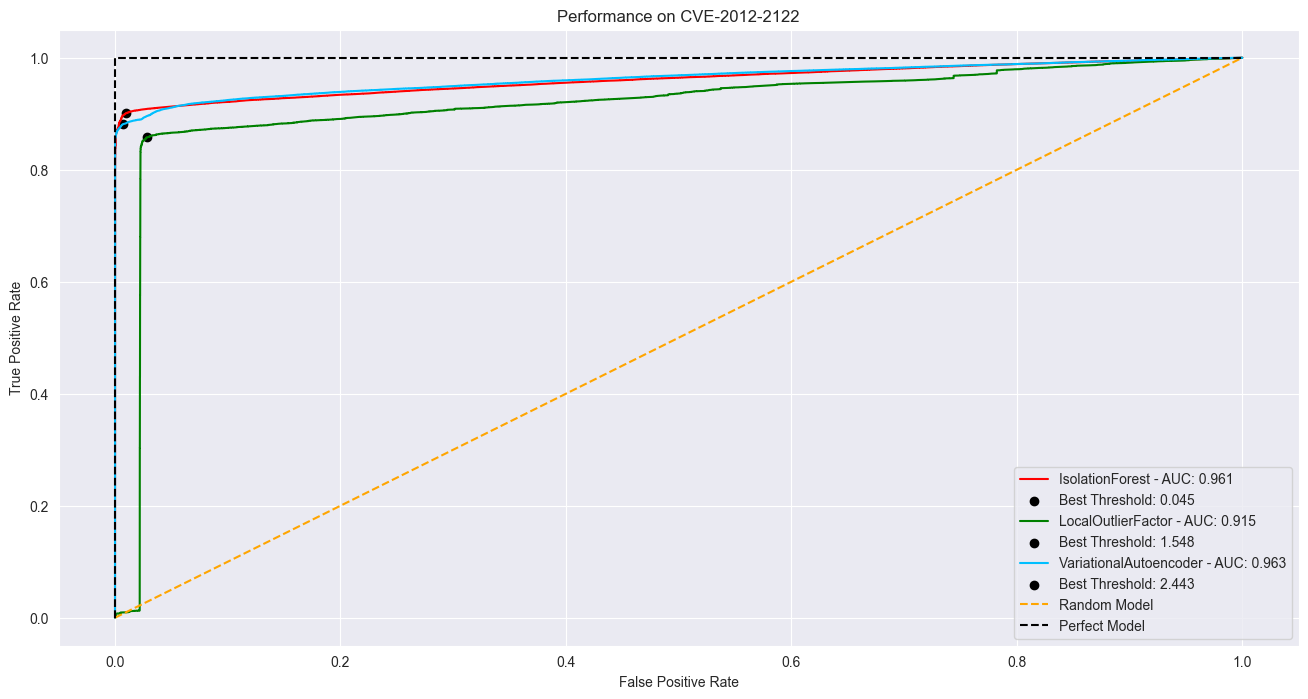

1070/1070 [==============================] - 0s 359us/step


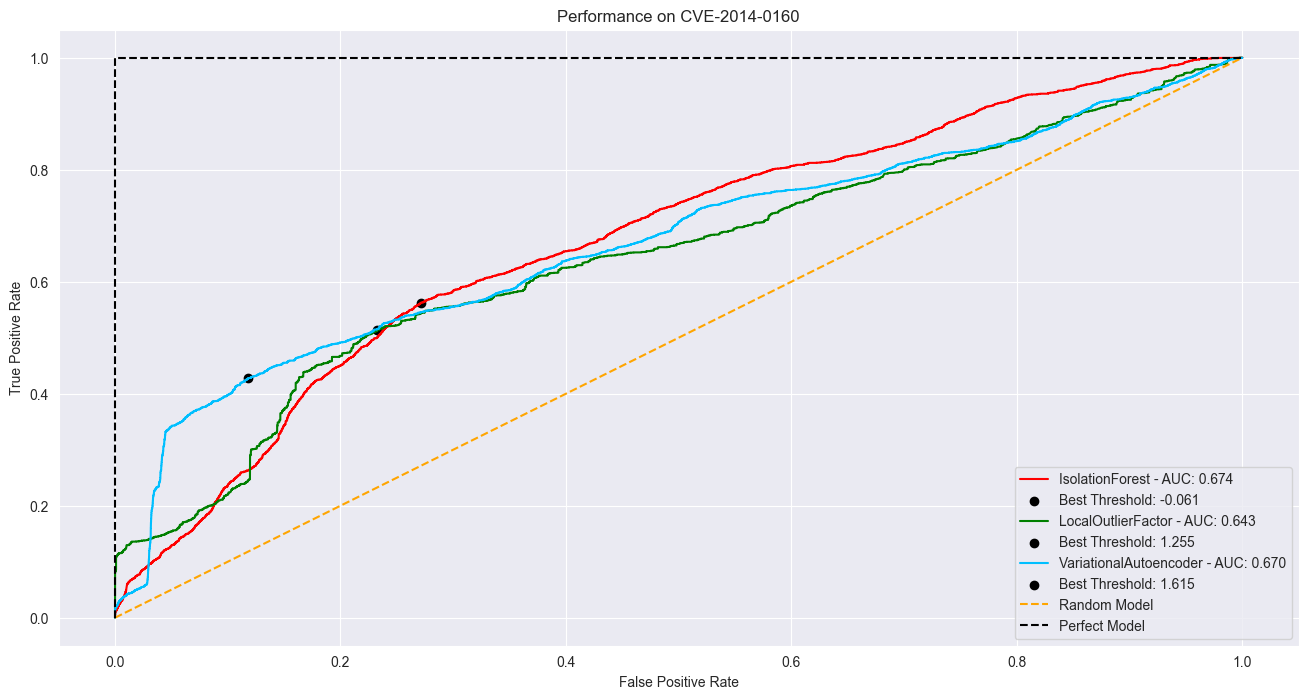

700/700 [==============================] - 0s 363us/step


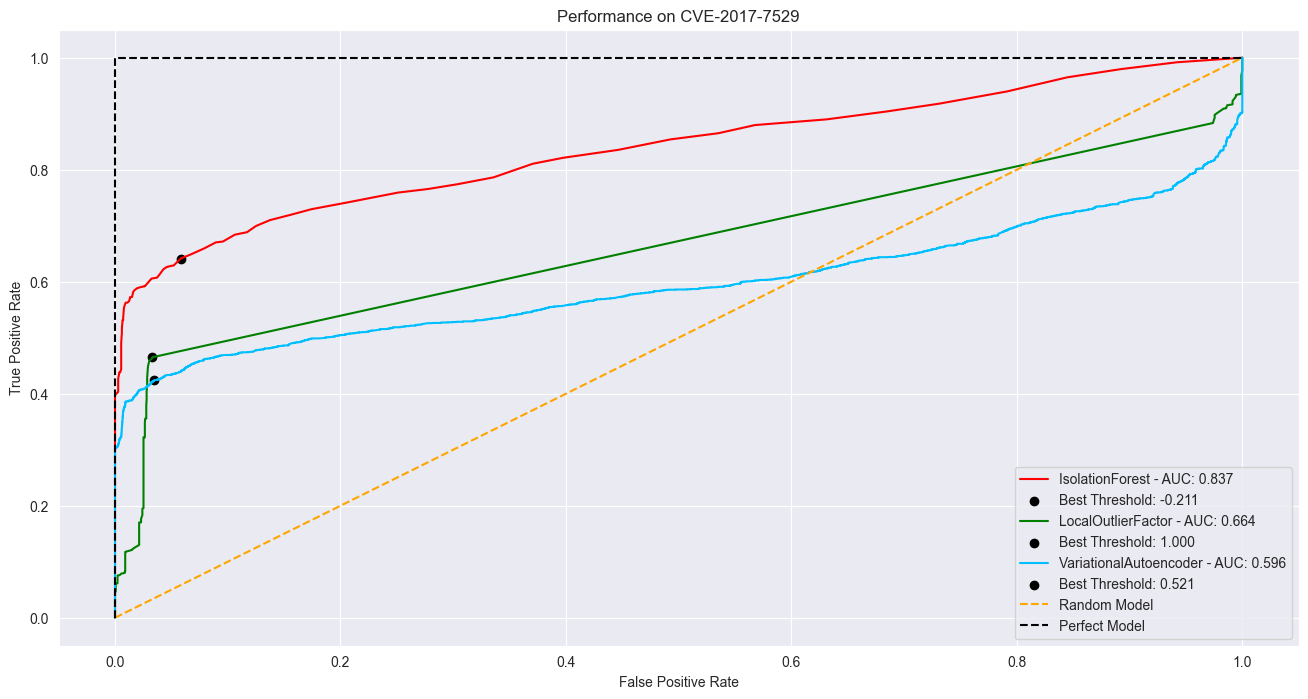

1083/1083 [==============================] - 0s 364us/step


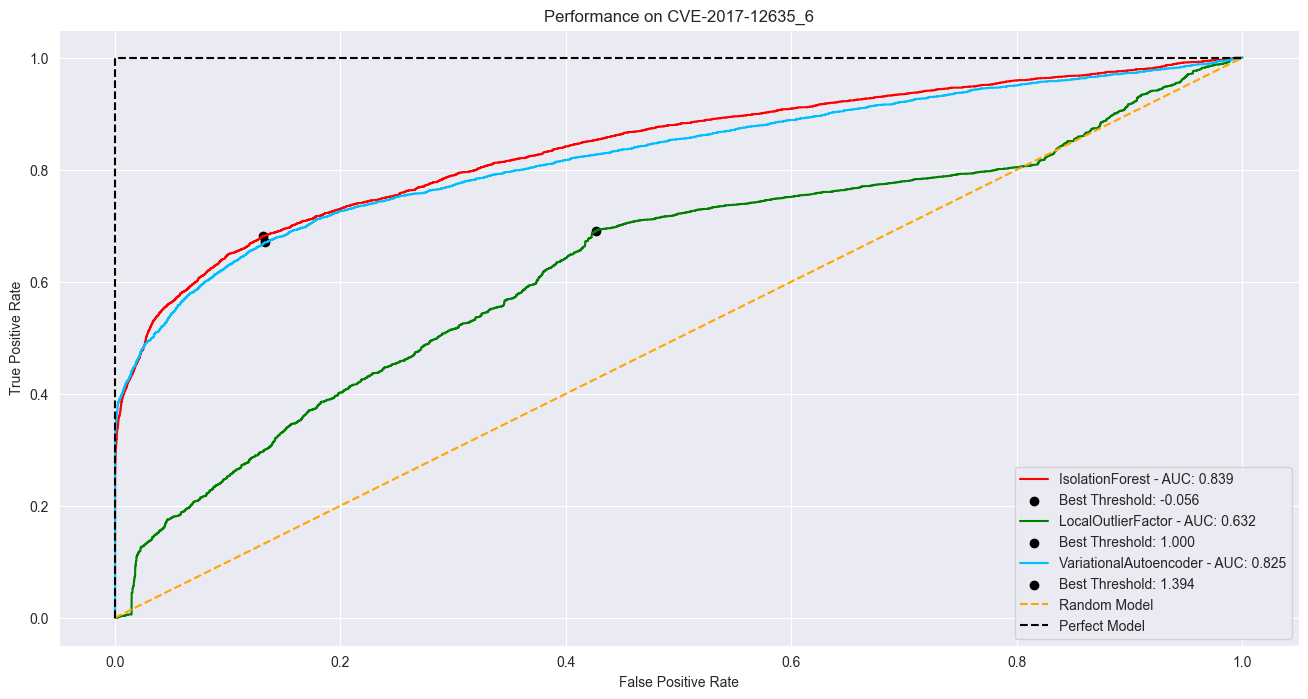

935/935 [==============================] - 0s 366us/step


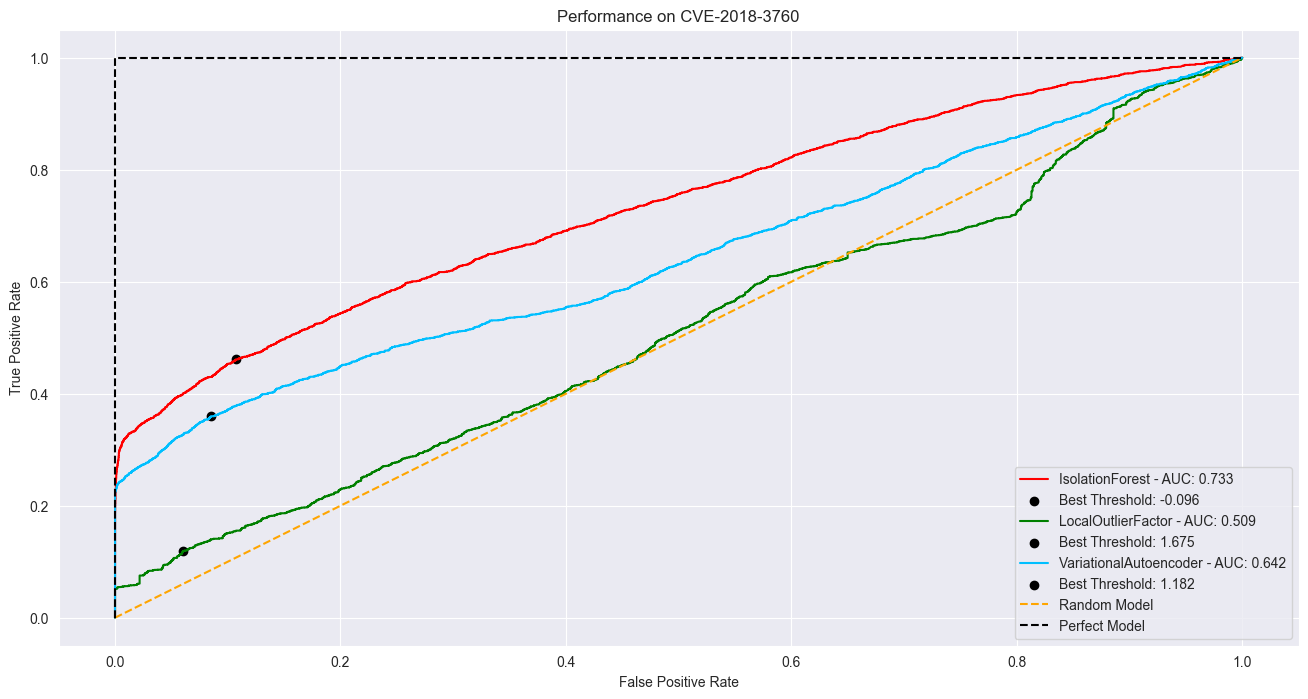

1063/1063 [==============================] - 0s 374us/step


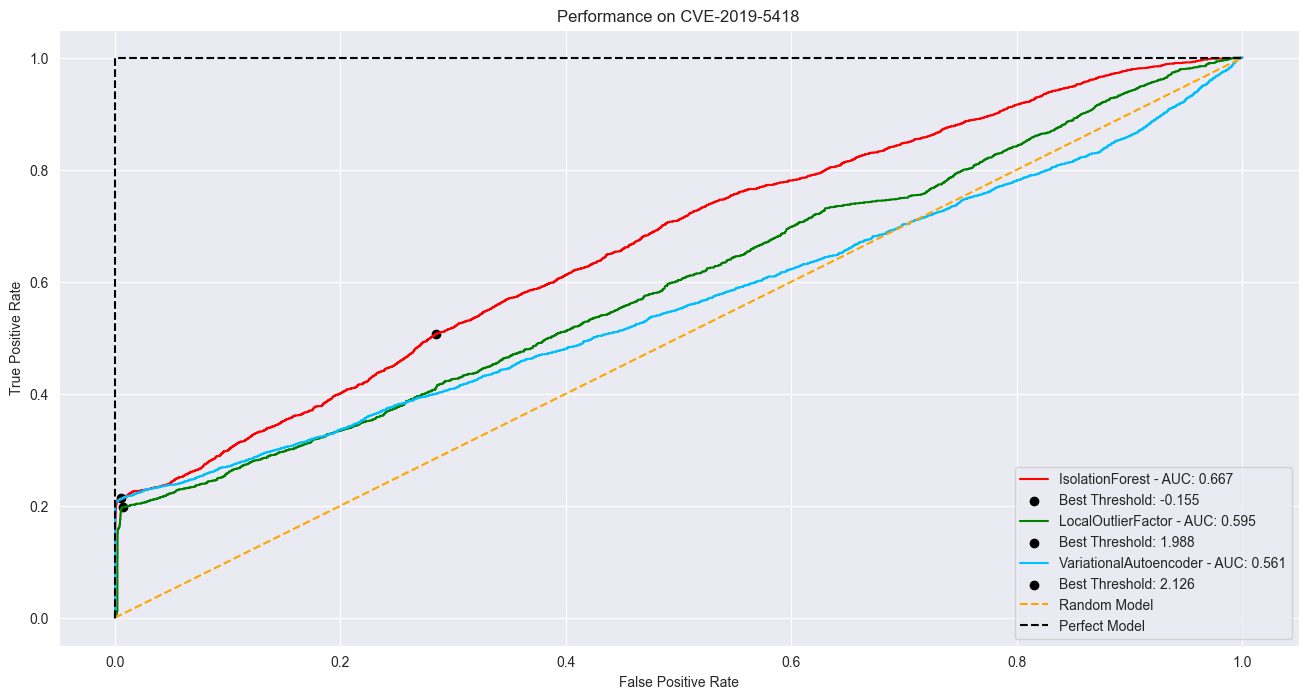

972/972 [==============================] - 0s 369us/step


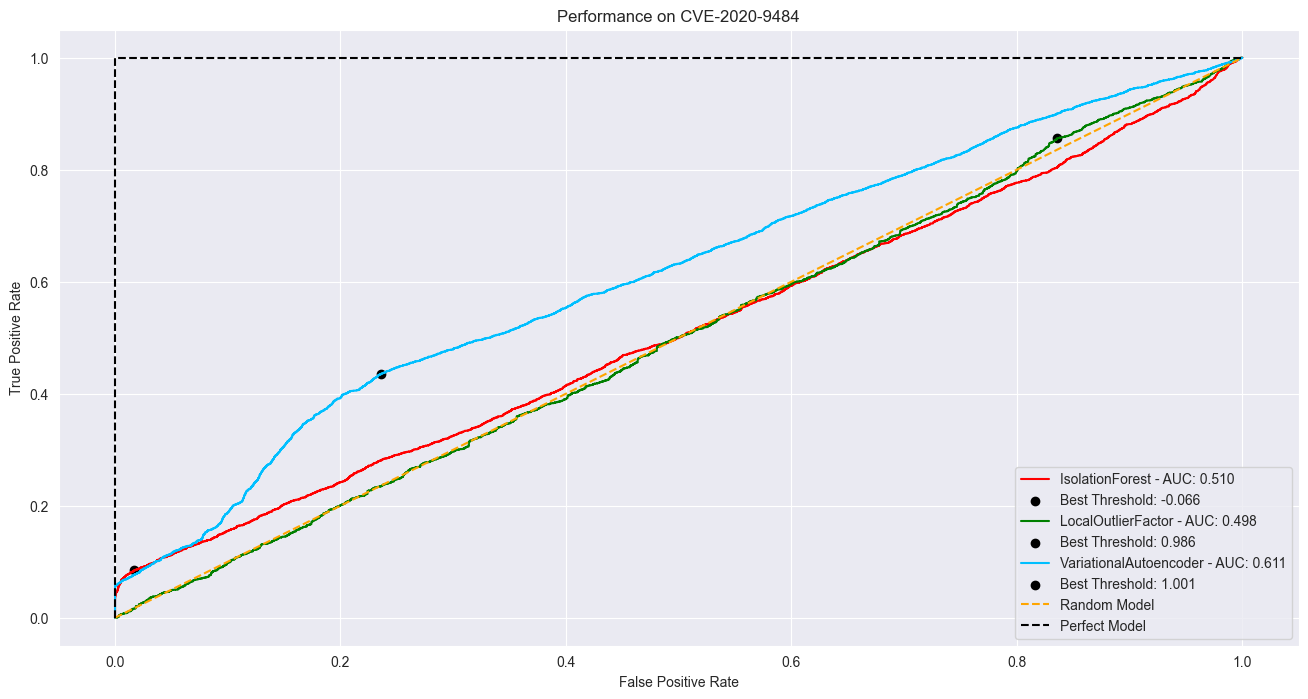

983/983 [==============================] - 0s 365us/step


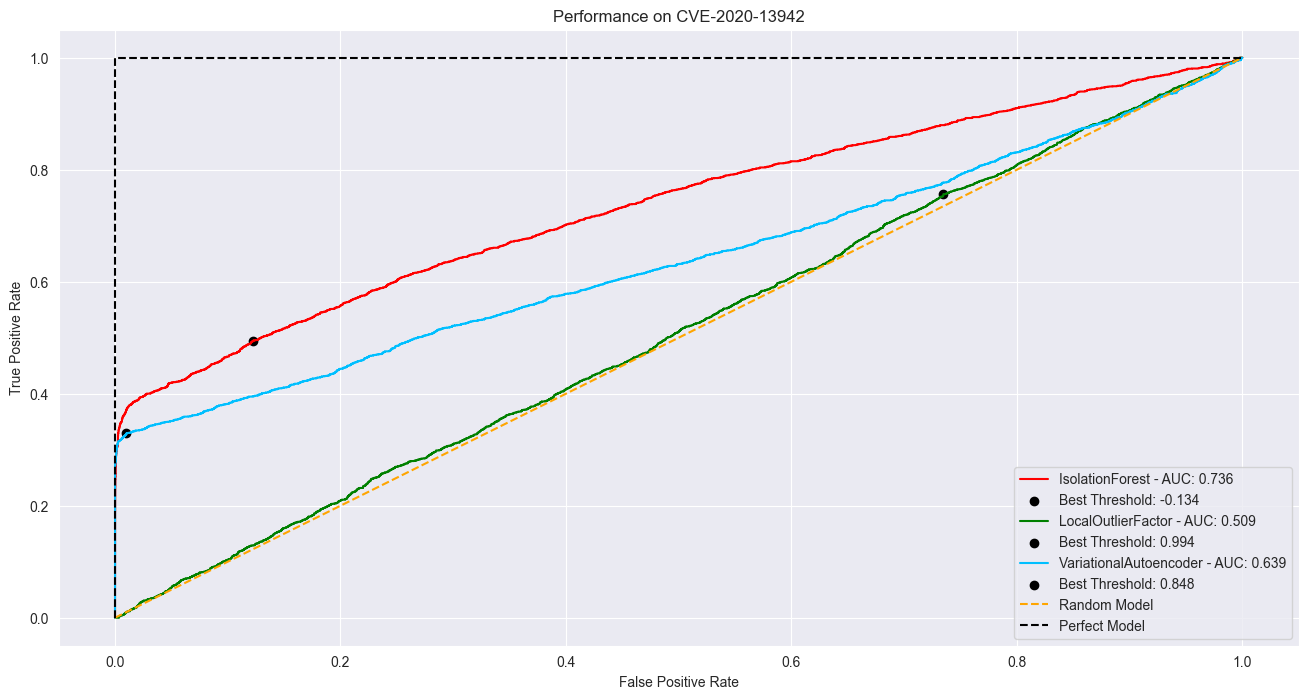

1116/1116 [==============================] - 0s 369us/step


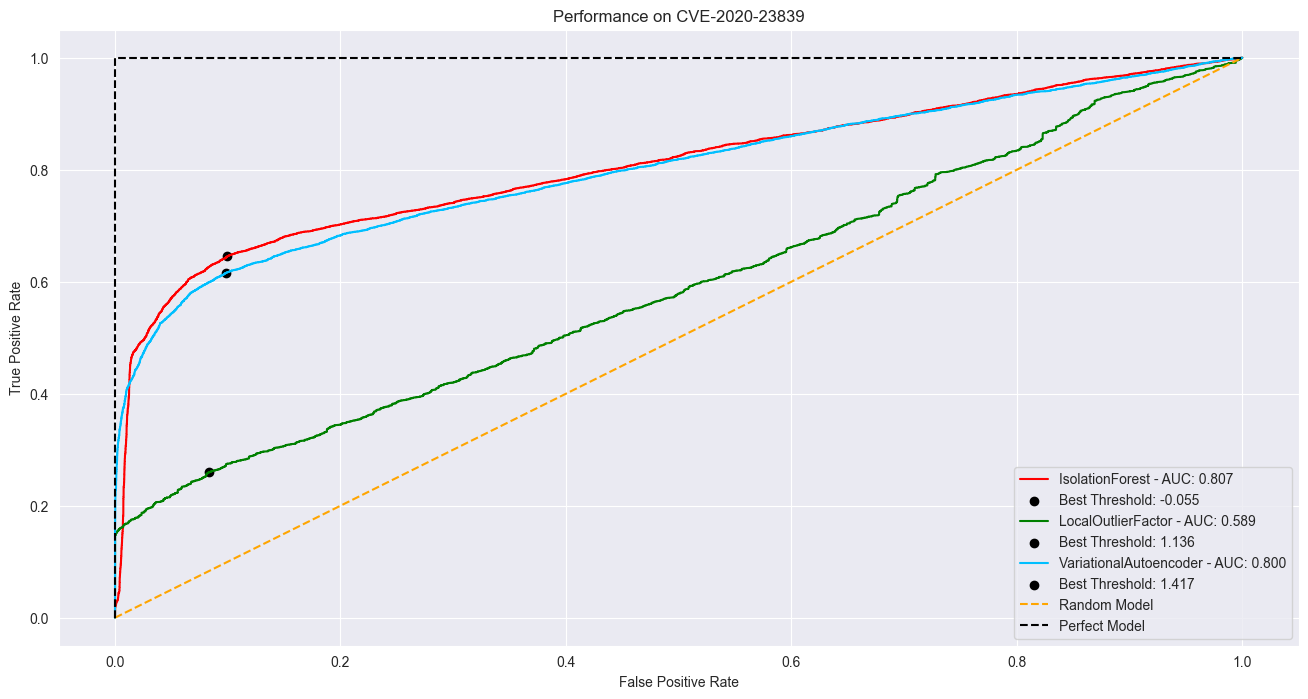

1141/1141 [==============================] - 0s 404us/step


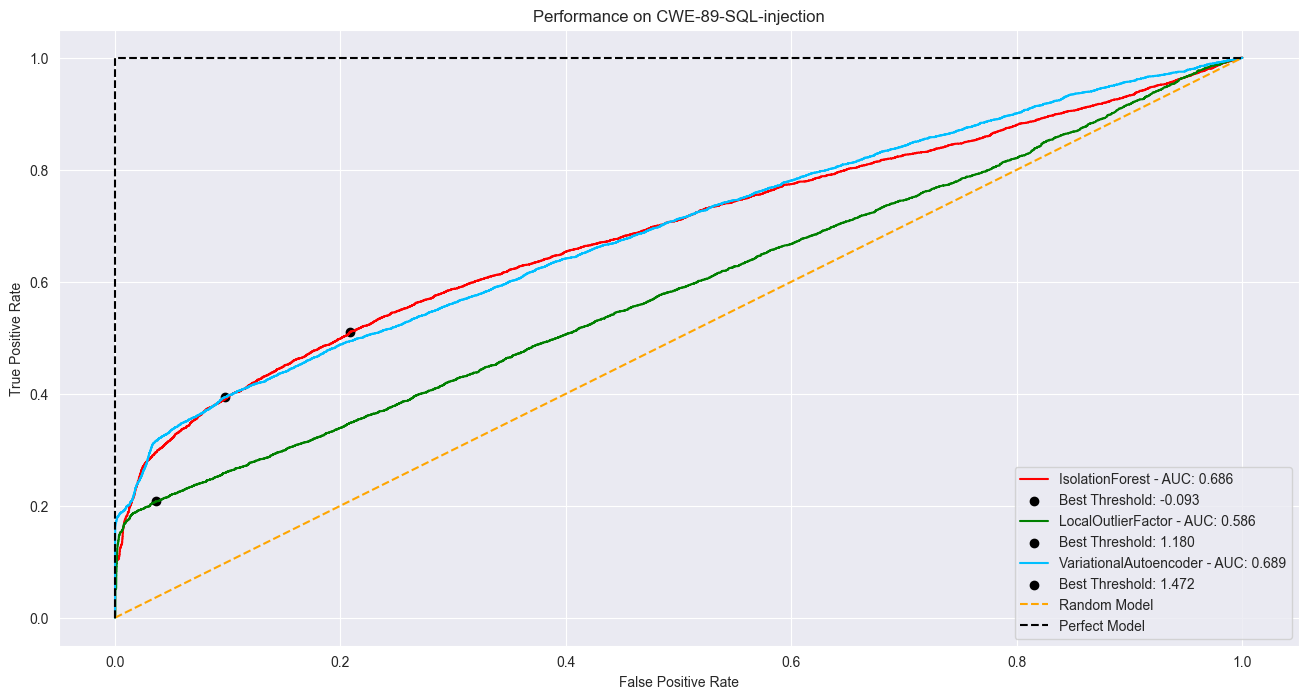

In [9]:
sns.set_style("darkgrid")
name = ["IsolationForest", "LocalOutlierFactor", "VariationalAutoencoder"]
colors = ["red", "green", "deepskyblue"]
# Create plots for all scenarios
for i in range(0, len(scenarios)):
    # prepare test data
    X_test = no_outliers[scenarios[i]]
    X_test = select_columns_for_modelling(X_test)

    algorithms = [IsoForests[scenarios[i]], lof_[scenarios[i]], vae[scenarios[i]]]

    fig = plt.figure(figsize=(16, 8))
    for a, algo in enumerate(algorithms):
        algo_test = algo.decision_function(X_test)

        fpr_test_, tpr_test_, thresholds = roc_curve(y_true[scenarios[i]], algo_test)
        algo_auc_test = auc(fpr_test_, tpr_test_)
        J = tpr_test_ - fpr_test_
        ix = np.argmax(J)
        best_thresh = thresholds[ix]
        # print(str(name[a]) + ': Best Threshold %f' % (best_thresh))

        plt.subplot(1, 1, 1)
        plt.title("Performance on " + scenarios[i])
        plt.plot(
            fpr_test_,
            tpr_test_,
            color=colors[a],
            label="{0} - AUC: {1:.3f}".format(name[a], algo_auc_test),
        )
        plt.scatter(
            fpr_test_[ix],
            tpr_test_[ix],
            marker="o",
            color="black",
            label="Best Threshold: {1:.3f}".format(name[a], best_thresh),
        )
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")

    plt.subplot(1, 1, 1)
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random Model", color="orange")
    plt.plot([0, 0, 1], [0, 1, 1], linestyle="--", label="Perfect Model", color="black")
    plt.legend(loc=0)
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))

    plt.show()
    fig.savefig(
        "../../src/plots/models/EVALUATION_ALLMODELS_NO_OUTLIERS"
        + scenarios[i]
        + ".png"
    )

## Evaluation after adjusting contamination rate dynamically 

In [10]:
# load each model for each Scenario

model_type = "IsolationForest"
IsoForests = {}
for i in range(0, len(scenarios)):
    # get dict and save mofel for each scenario
    IsoForests[scenarios[i]] = load_model(
        model_type=model_type,
        train_data=TRAIN,
        test_data=TEST,
        scenario=scenarios[i],
        contamination_rate=True,
    )

model_type = "LocalOutlierFactor"
lof_ = {}
for i in range(0, len(scenarios)):
    # get dict and save mofel for each scenario
    lof_[scenarios[i]] = load_model(
        model_type=model_type,
        train_data=TRAIN,
        test_data=TEST,
        scenario=scenarios[i],
        contamination_rate=True,
    )

model_type = "VariationalAutoencoder"
vae = {}
for i in range(0, len(scenarios)):
    # get dict and save mofel for each scenario
    vae[scenarios[i]] = load_model(
        model_type=model_type,
        train_data=TRAIN,
        test_data=TEST,
        scenario=scenarios[i],
        contamination_rate=True,
    )

CVE-2012-2122:0.5
CVE-2014-0160:0.07508720930232558
CVE-2017-7529:0.07513427734375
CVE-2017-12635_6:0.1007916188458256
CVE-2018-3760:0.07467131983513343
CVE-2019-5418:0.07250172691687773
CVE-2020-9484:0.09392249226945641
CVE-2020-13942:0.0708319995343829
CVE-2020-23839:0.1532595823344213
CWE-89-SQL-injection:0.1235052806144715
CVE-2012-2122:0.5
CVE-2014-0160:0.07508720930232558
CVE-2017-7529:0.07513427734375
CVE-2017-12635_6:0.1007916188458256
CVE-2018-3760:0.07467131983513343
CVE-2019-5418:0.07250172691687773
CVE-2020-9484:0.09392249226945641
CVE-2020-13942:0.0708319995343829
CVE-2020-23839:0.1532595823344213
CWE-89-SQL-injection:0.1235052806144715
CVE-2012-2122:0.5
301/301 [==============================] - 0s 380us/step
CVE-2014-0160:0.07508720930232558
299/299 [==============================] - 0s 377us/step
CVE-2017-7529:0.07513427734375
296/296 [==============================] - 0s 414us/step
CVE-2017-12635_6:0.1007916188458256
294/294 [==============================] - 0s 377us/

IsolationForest: Best Threshold 0.142805
LocalOutlierFactor: Best Threshold 1.547630
3983/3983 [==============================] - 2s 386us/step
VariationalAutoencoder: Best Threshold 2.459844


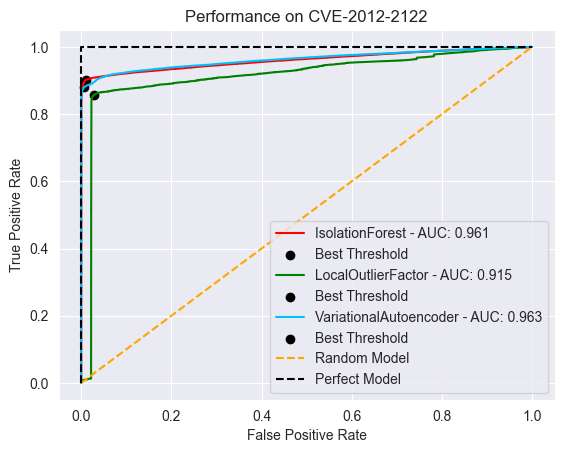

IsolationForest: Best Threshold -0.082130
LocalOutlierFactor: Best Threshold 1.255012
1070/1070 [==============================] - 0s 387us/step
VariationalAutoencoder: Best Threshold 1.624558


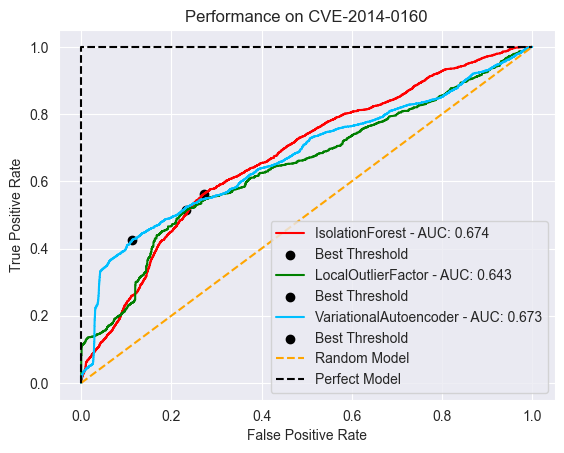

IsolationForest: Best Threshold -0.224852
LocalOutlierFactor: Best Threshold 1.000000
700/700 [==============================] - 0s 386us/step
VariationalAutoencoder: Best Threshold 0.521144


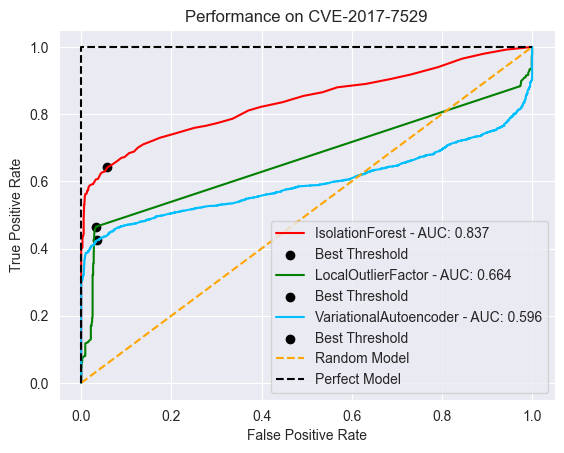

IsolationForest: Best Threshold -0.056107
LocalOutlierFactor: Best Threshold 1.000000
1083/1083 [==============================] - 0s 388us/step
VariationalAutoencoder: Best Threshold 1.391636


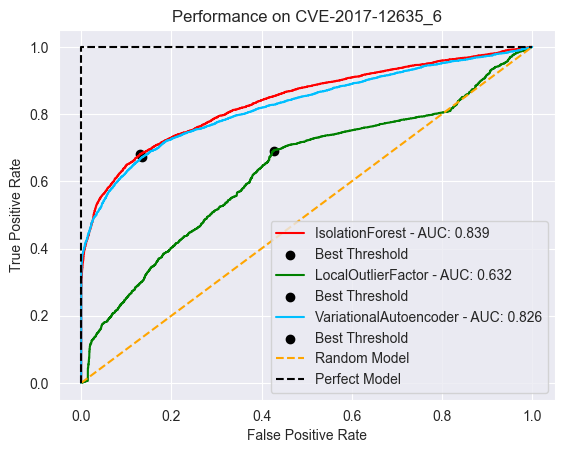

IsolationForest: Best Threshold -0.112886
LocalOutlierFactor: Best Threshold 1.674914
935/935 [==============================] - 0s 384us/step
VariationalAutoencoder: Best Threshold 1.180965


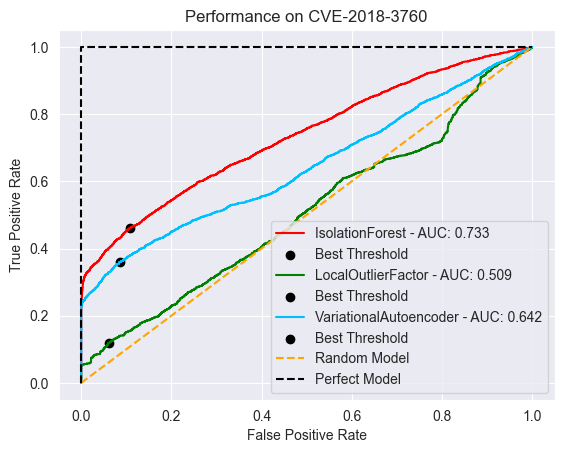

IsolationForest: Best Threshold -0.169026
LocalOutlierFactor: Best Threshold 1.987530
1063/1063 [==============================] - 0s 386us/step
VariationalAutoencoder: Best Threshold 2.125759


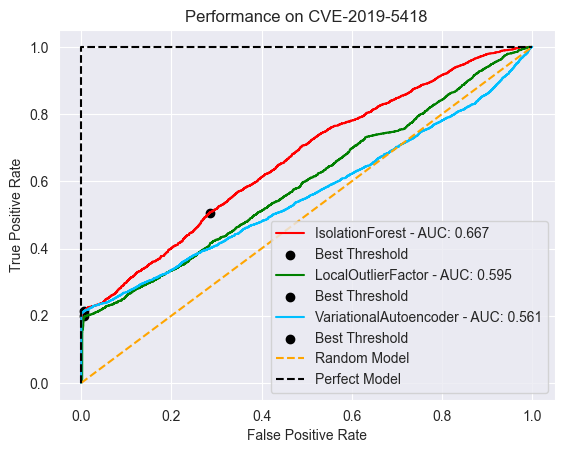

IsolationForest: Best Threshold -0.068230
LocalOutlierFactor: Best Threshold 0.986250
972/972 [==============================] - 0s 389us/step
VariationalAutoencoder: Best Threshold 0.998989


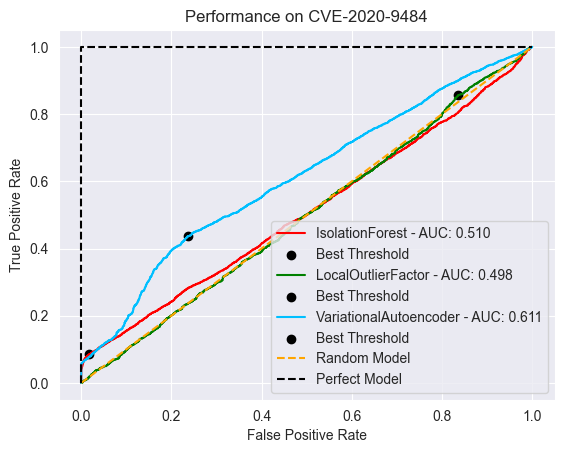

IsolationForest: Best Threshold -0.165857
LocalOutlierFactor: Best Threshold 0.993694
983/983 [==============================] - 0s 390us/step
VariationalAutoencoder: Best Threshold 0.847282


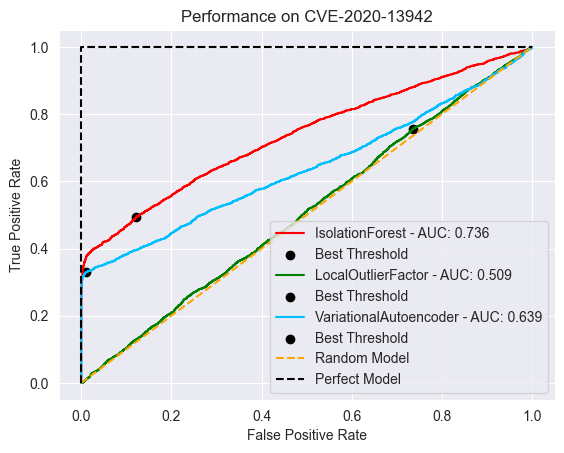

IsolationForest: Best Threshold -0.031477
LocalOutlierFactor: Best Threshold 1.136132
1116/1116 [==============================] - 0s 388us/step
VariationalAutoencoder: Best Threshold 1.420397


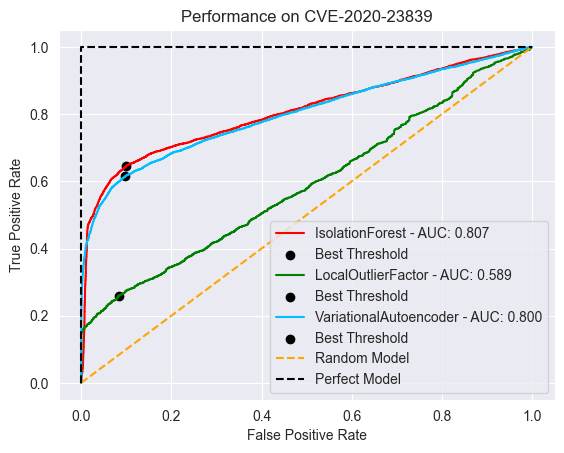

IsolationForest: Best Threshold -0.082609
LocalOutlierFactor: Best Threshold 1.180198
1141/1141 [==============================] - 0s 410us/step
VariationalAutoencoder: Best Threshold 1.471389


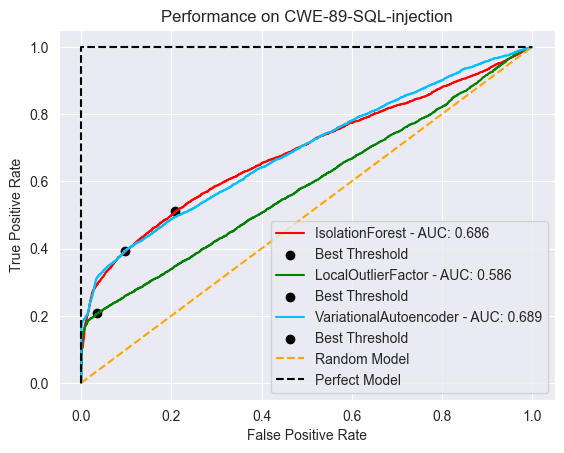

In [11]:
sns.set_style("darkgrid")
name = ["IsolationForest", "LocalOutlierFactor", "VariationalAutoencoder"]
colors = ["red", "green", "deepskyblue"]
# Create plots for all scenarios
for i in range(0, len(scenarios)):
    # prepare test data
    X_test = no_outliers[scenarios[i]]
    X_test = select_columns_for_modelling(X_test)

    algorithms = [IsoForests[scenarios[i]], lof_[scenarios[i]], vae[scenarios[i]]]

    fig = plt.figure()
    for a, algo in enumerate(algorithms):
        algo_test = algo.decision_function(X_test)

        fpr_test_, tpr_test_, thresholds = roc_curve(y_true[scenarios[i]], algo_test)
        algo_auc_test = auc(fpr_test_, tpr_test_)
        J = tpr_test_ - fpr_test_
        ix = np.argmax(J)
        best_thresh = thresholds[ix]
        print(str(name[a]) + ": Best Threshold %f" % (best_thresh))

        plt.subplot(1, 1, 1)
        plt.title("Performance on " + scenarios[i])
        plt.plot(
            fpr_test_,
            tpr_test_,
            color=colors[a],
            label="{0} - AUC: {1:.3f}".format(name[a], algo_auc_test),
        )
        plt.scatter(
            fpr_test_[ix],
            tpr_test_[ix],
            marker="o",
            color="black",
            label="Best Threshold",
        )

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")

    plt.subplot(1, 1, 1)
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random Model", color="orange")
    plt.plot([0, 0, 1], [0, 1, 1], linestyle="--", label="Perfect Model", color="black")
    plt.legend(loc=0)
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))

    plt.show()
    fig.savefig(
        "../../src/plots/models/EVALUATION_ALLMODELS_Contaminataion_rate"
        + scenarios[i]
        + ".png"
    )